In [2]:
import tensorflow as tf

print("GPUs disponibles :", tf.config.list_physical_devices('GPU'))


GPUs disponibles : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#  brain tumor detection model using a **CONVOLUTIONAL NEURAL NETWORK (CNN)** 

### STEP 1: IMPORTING ALL THE NECESARY LIBRARIES:

The code starts by importing the required libraries for data manipulation, visualization, and building the Convolutional Neural Network (CNN) model with highest possible accuracy using tensorflow.

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


### STEP 2: SETTING UP THE DATASET PATHS AND DIRECTORIES: 


In [5]:
# Set the path to the dataset
dataset = "./brain_tumor_data"

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]


Here, the **dataset** variable is set to the root directory containing all the brain tumor MRI images.
The **categories** list defines the different types of brain tumors present in the dataset.





### STEP 3: LOADING AND PREPROCESSING THE DATASET: 

1. The code reads the images from each category in the training directory, counts the number of images in each category, and creates a Pandas DataFrame (***train_df***) to store the image filenames, corresponding categories, and counts.

2. A bar plot is generated to visualize the distribution of tumor types in the training dataset.


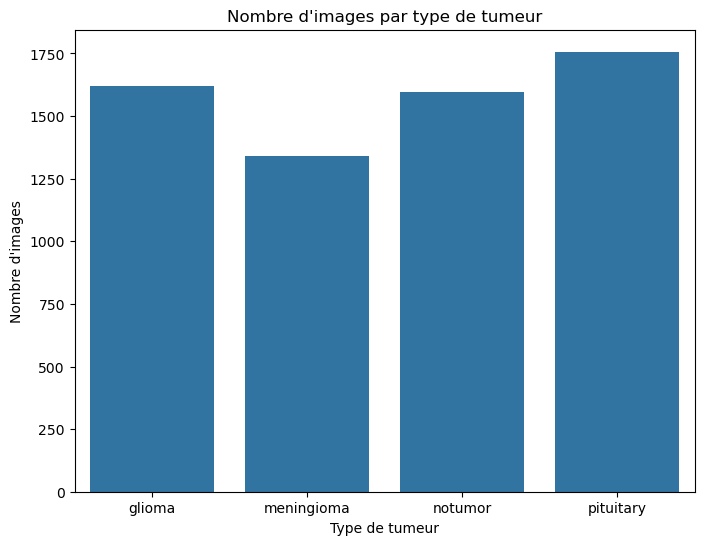

In [6]:
category_counts = []

# Compter le nombre d’images dans chaque catégorie
for category in categories:
    folder_path = os.path.join(dataset, category)
    if not os.path.exists(folder_path):
        print(f"⚠️ Dossier manquant : {folder_path}")
        continue
    
    num_images = len(os.listdir(folder_path))
    category_counts.append({"Category": category, "Count": num_images})

# Convertir en DataFrame
df_counts = pd.DataFrame(category_counts)

# Affichage du barplot
plt.figure(figsize=(8, 6))
sns.barplot(data=df_counts, x="Category", y="Count")
plt.title("Nombre d'images par type de tumeur")
plt.xlabel("Type de tumeur")
plt.ylabel("Nombre d'images")
plt.show()

In [ ]:
import cv2
image_size = (150, 150)

X = []
y = []

for idx, category in enumerate(categories):
    folder_path = os.path.join(dataset, category)
    for img_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, img_name)
        try:
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                X.append(img)
                y.append(idx)
            else:
                print(f"[SKIPPED - UNREADABLE] {file_path}")
        except Exception as e:
            print(f"[ERROR] {file_path} -> {e}")

X = np.array(X)
y = np.array(y)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 1. Diviser en train (80%) et test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Diviser l'ensemble train_val en train (70%) et validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)  # 0.125 * 0.8 = 0.1

# 3. Convertir les labels en catégoriques
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))


In [9]:
print(f"Training data: {X_train.shape[0]} samples")
print(f"Validation data: {X_val.shape[0]} samples")
print(f"Test data: {X_test.shape[0]} samples")

Training data: 4417 samples
Validation data: 632 samples
Test data: 1263 samples


### STEP 4: VISUALIZING IMAGES FOR EACH TUMOR TYPES: 

Here, the code displays sample images for each tumor type using a grid of subplots.


In [8]:
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

NameError: name 'train_dir' is not defined

<Figure size 1200x800 with 0 Axes>

### STEP 5: SETTING UP THE IMAGE_SIZE, BATCH_SIZE AND EPOCHS FOR THE MODEL:

The ***image_size*** variable defines the desired size for the input images in the CNN. The ***batch_size*** specifies the number of images to be processed in each training batch, and ***epochs*** determines the number of times the entire training dataset is iterated during training.


In [10]:

# Set the image size
image_size = (150, 150)
# Set the batch size for training
batch_size = 64

# Set the number of epochs for training
epochs = 50

### STEP 6: DATA AUGMENTATION AND PREPROCESSING:

In [11]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=batch_size,
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow(
   X_test, y_test,
    batch_size=batch_size,
    shuffle=False
)


**DATA AUGMENTATION** is performed using ***ImageDataGenerator*** class from Keras. It applies various transformations to the training imags to artificially increase the size of the dataset and improve the generalization. The aumentation paramters include rescaling the pixel values, rotation, shifting, shearing, zooming and flipping. The ***train_generator*** is created using the augmented data, and the ***test_generator*** is created with only pixel rescaling for the test dataset.

### STEP 6 : Adding a pretrained model


In [21]:
from tensorflow.keras.applications import VGG16
vgg_base = VGG16(
    weights='imagenet',       # Utiliser les poids préentraînés sur ImageNet
    include_top=False,        # Ne pas inclure la partie "fully connected" finale
    input_shape=(image_size[0], image_size[1], 3)  # Ton image (150x150x3)
)
for layer in vgg_base.layers:
    layer.trainable = False

### STEP 7: BUILDING THE MODEL ARTITECHURE

In [22]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    vgg_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')  # Nombre de classes dans ta variable categories
])
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

1. The model architecture is defined using a sequential model (**Sequential class**). It consists of a series of convolutional (**Conv2D**) and max pooling (**MaxPooling2D**) layers, followed by a **flattening layer**, two fully connected (**Dense**) layers, and a **dropout layer for regularization**. 
2. The activation function used for the convolutional layers is **ReLU**, except for the last dense layer, where **softmax activation** is used to output class probabilities.
3. The model is compiled with the **Adam optimizer**, which is an adaptive learning rate optimization algorithm. The loss function used is **categorical cross-entropy**, suitable for multi-class classification problems with **one-hot encoded labels**. 
4. The accuracy metric is also specified to monitor the model's performance during training.

In [23]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 18,911,556
Trainable params: 4,196,868
Non-trainable params: 14,714,688
_________________________________________________________________


In [24]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))  # Doit afficher votre GPU
print(tf.test.is_built_with_cuda())  # Doit retourner True

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [25]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,)

Epoch 1/50
70/70 [==============================] - 116s 2s/step - loss: 0.9827 - accuracy: 0.6649 - val_loss: 0.5206 - val_accuracy: 0.8052
Epoch 2/50
70/70 [==============================] - 168s 2s/step - loss: 0.5203 - accuracy: 0.7976 - val_loss: 0.4633 - val_accuracy: 0.8321
Epoch 3/50
70/70 [==============================] - 187s 3s/step - loss: 0.5299 - accuracy: 0.7996 - val_loss: 0.4180 - val_accuracy: 0.8464
Epoch 4/50
70/70 [==============================] - 227s 3s/step - loss: 0.4497 - accuracy: 0.8275 - val_loss: 0.3980 - val_accuracy: 0.8440
Epoch 5/50
70/70 [==============================] - 148s 2s/step - loss: 0.4383 - accuracy: 0.8393 - val_loss: 0.4194 - val_accuracy: 0.8472
Epoch 6/50
70/70 [==============================] - 90s 1s/step - loss: 0.4085 - accuracy: 0.8474 - val_loss: 0.3788 - val_accuracy: 0.8654
Epoch 7/50
70/70 [==============================] - 113s 2s/step - loss: 0.4312 - accuracy: 0.8325 - val_loss: 0.3294 - val_accuracy: 0.8646
Epoch 8/50
70/

The model is trained using the **fit** method. The ***train_generator*** provides the **training data**, and the ***test_generator*** provides the **validation data**. 

### STEP 8: VISUALIZATION 

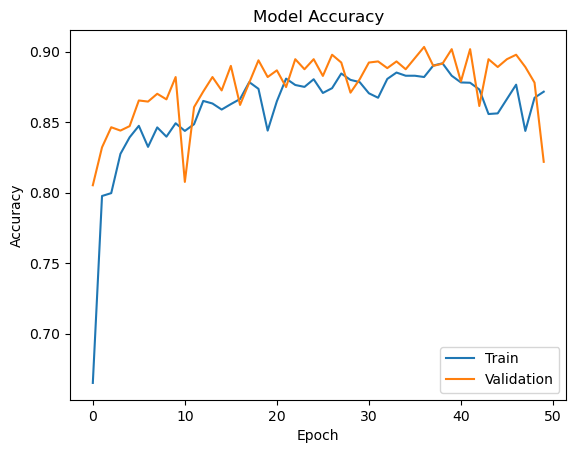

In [26]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

This code plots the training and validation accuracy over epochs using the data stored in history. It helps visualize the model's learning progress and check for overfitting or underfitting.

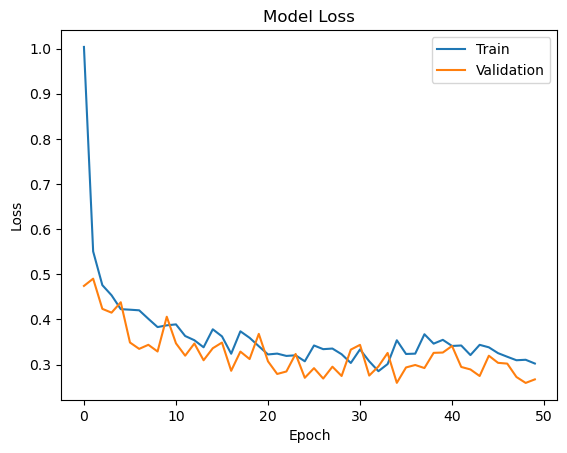

In [19]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

This code plots the training and validation loss over epochs using the data stored in **history**. It helps visualize how the model's loss decreases over time, indicating improved performance.



### STEP 9: EVALUATION

In [1]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

NameError: name 'model' is not defined

1. In the above evaluation ***model.evaluate*** (***test_generator***) evaluates the trained model on the **test dataset**. It calculates the loss and accuracy of the model's predictions on the test data.

2. The ***loss*** value represents the average loss (error) of the model's predictions compared to the ground truth labels in the test dataset. A lower loss value indicates that the model's predictions are closer to the actual labels, indicating better performance.

3. The ***accuracy*** value represents the proportion of correctly classified samples in the test dataset. It is calculated by dividing the number of correctly predicted samples by the total number of samples in the dataset. A higher accuracy value indicates that the model has made more correct predictions.

4. In the given example, the **test loss** is **0.1699**, which means that, on average, the model's predictions deviate by a small margin from the true labels in the test dataset. The **test accuracy is 0.9627**, indicating that the model has achieved an **accuracy** of approximately **96.27% on the test data**, correctly classifying the tumor types in the majority of the cases.

6. **These evaluation metrics provide insights into the model's performance on unseen data and help assess its generalization capabilities.**

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


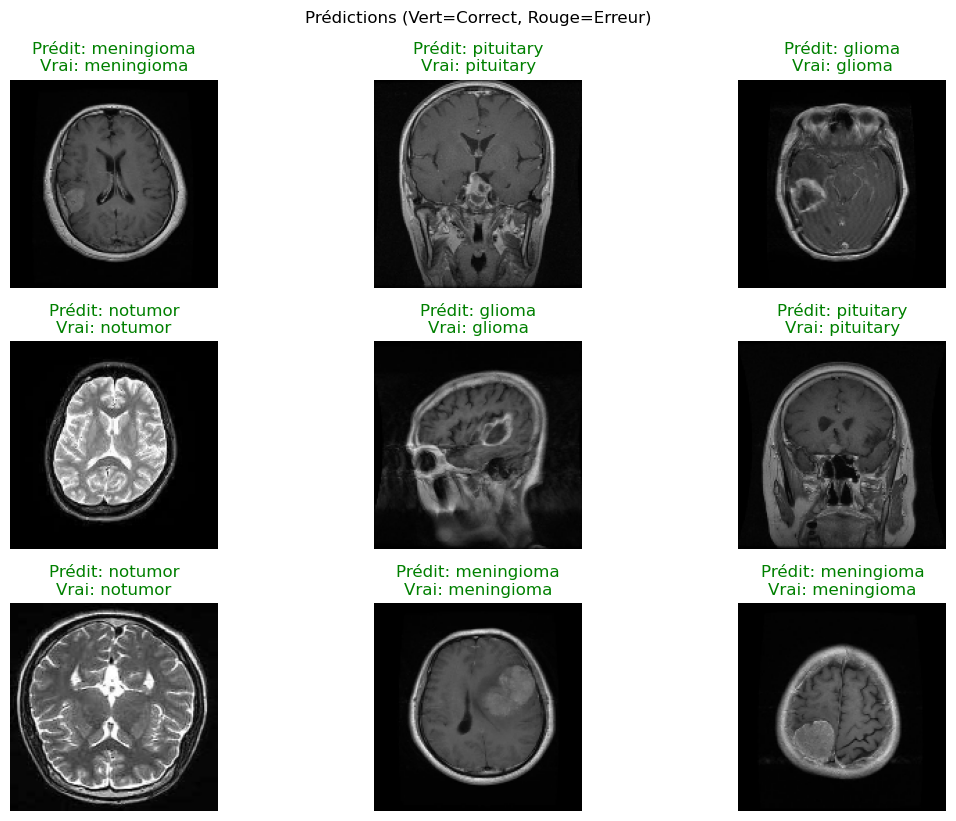


Précision globale: 96.28%
Nombre total d'échantillons: 1263
Exemples corrects: 1216
Erreurs: 47


In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Prédictions
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Vérification du format des labels (one-hot ou non)
if y_test.ndim > 1 and y_test.shape[1] > 1:
    true_labels = np.argmax(y_test, axis=1)
else:
    true_labels = y_test

# Sélection aléatoire de 9 échantillons
sample_indices = np.random.choice(range(len(X_test)), size=min(9, len(X_test)), replace=False)

# Préparation de l'affichage
plt.figure(figsize=(12, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, i+1)
    img = X_test[idx]
    plt.imshow(img)
    
    # Détermination de la couleur
    if predicted_labels[idx] == true_labels[idx]:
        text_color = 'green'  # Correct -> Vert
    else:
        text_color = 'red'    # Erreur -> Rouge
    
    plt.title(f"Prédit: {categories[predicted_labels[idx]]}\nVrai: {categories[true_labels[idx]]}", 
              color=text_color)
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Prédictions (Vert=Correct, Rouge=Erreur)", y=1.02)
plt.show()

# Affichage des statistiques
accuracy = np.mean(predicted_labels == true_labels)
print(f"\nPrécision globale: {accuracy:.2%}")
print(f"Nombre total d'échantillons: {len(X_test)}")
print(f"Exemples corrects: {np.sum(predicted_labels == true_labels)}")
print(f"Erreurs: {np.sum(predicted_labels != true_labels)}") 

In [57]:
import pandas as pd
from sklearn.metrics import classification_report

# 1. Obtenir les prédictions
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = np.argmax(y_test, axis=1)  # si y_test est en one-hot encoding

# 2. Générer le rapport et le convertir en DataFrame
report = classification_report(y_true, y_pred, 
                             target_names=categories,
                             output_dict=True,
                             digits=4)

# 3. Filtrer pour ne garder que les classes et supprimer 'support'
report_df = pd.DataFrame(report).transpose()
report_df = report_df.loc[categories, ['precision', 'recall', 'f1-score']]  # Sélection spécifique

# 4. Afficher le tableau épuré
print("🔍 Rapport de Classification Simplifié:")
display(report_df.style\
       .background_gradient(cmap="Blues", vmin=0, vmax=1)\
       .format("{:.4f}"))

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step
🔍 Rapport de Classification Simplifié:


,precision,recall,f1-score
glioma,0.9941,0.9385,0.9655
meningioma,0.9147,0.9365,0.9255
notumor,0.9610,0.9969,0.9786
pituitary,0.9701,0.9759,0.9730




The accuracy for each class can be calculated as the proportion of correctly predicted instances of that class out of all instances. Here are the accuracies for each class:

**Glioma: 99.4%
Meningioma: 91.47%
No Tumor: 96.10%
Pituitary: 97.01%**



In [3]:
# Save the trained model
model.save("brain_tumor_data_Vgg16.h5")


NameError: name 'model' is not defined